# Pnevmatikakis 2014 : Greedy Initialization Algorithm

In [1]:
%matplotlib inline
import os, socket
import numpy as np
from matplotlib import pyplot as plt
import mpld3

In [2]:
import neuralyzer
from neuralyzer.im import smff

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (7,7)

In [4]:
if socket.gethostname() == 'kumo':
    #datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel0.tif'
    datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
    #datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_minitestdata.tif'
else:
    datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
data = neuralyzer.get_data(datafile)

[ 2015-04-21 18:30:25 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-21 18:30:25 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-21 18:30:25 ] [ data_handler ] [ DEBUG ] : root_path set to /home/michael/lib/neuralyzer/notebooks/dev
[ 2015-04-21 18:30:25 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif.hdf5


### reshape the data

In [5]:
dshape = data.shape
data = data.reshape((data.shape[0], data.shape[1]*data.shape[2])).T
data.shape

(65536, 1000)

### centering the data

In [6]:
## MEDIAN CENTERING
mediandata = np.median(data,axis=1)
Y = data - np.tile(mediandata, (data.shape[1], 1)).T

In [7]:
## MEAN CENTERING
meandata = np.mean(data,axis=1)
Y = data - np.tile(meandata, (data.shape[1], 1)).T

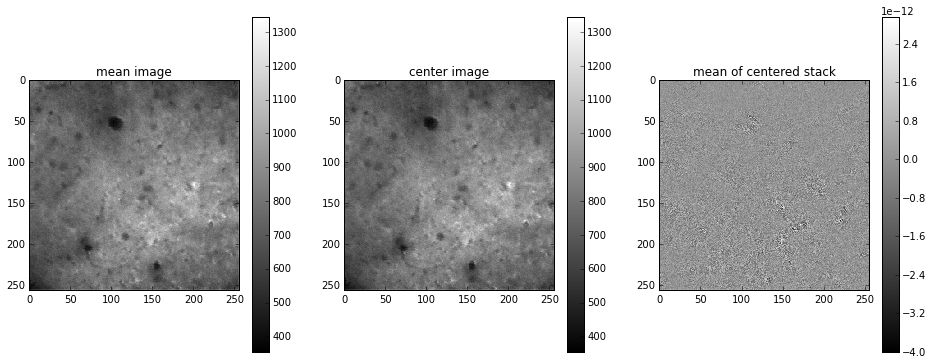

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

meanim = np.mean(data, axis=1).reshape(dshape[1:])
im = ax[0].imshow(meanim)
_ = plt.colorbar(im, ax=ax[0])
ax[0].set_title('mean image')
im = ax[1].imshow(meandata.reshape(dshape[1:]))
_ = plt.colorbar(im, ax=ax[1])
ax[1].set_title('center image')
im = ax[2].imshow(np.mean(Y, axis=1).reshape(dshape[1:]))
ax[2].set_title('mean of centered stack')
_ = plt.colorbar(im, ax=ax[2])

In [9]:
yshape = Y.shape
ytype = Y.dtype

In [10]:
yshape

(65536, 1000)

### memmap

In [10]:
memmapfile, _ = os.path.splitext(datafile)
memmapfile += '_memmap.dat'

In [11]:
# write the memorymap file
dmm = np.memmap(memmapfile, dtype=Y.dtype, shape=Y.shape, mode='w+')
dmm[:] = Y[:]
del dmm, Y

In [13]:
dmm = np.memmap(memmapfile, dtype=ytype, shape=yshape, mode='r')

## Gaussian Kernel

In [29]:
2**6

64

In [32]:
# Memory conserdations toy example
datarows = 16384
datacols = 100
mem = datarows*datacols*2**3/1024**2
print 'memory needed: %s MB' % mem

memory needed: 12 MB


In [33]:
# real data example
datarows = 512**2
datacols = 18000
mem = datarows*datacols*2**3/1024**3
print 'memory needed: %s GB' % mem

memory needed: 35 GB


In [25]:
# available memory on kumo : 181535412k
181535412/1024**2

173

**in principle it should be possible to calculate $Y \times D$ on kumo for the entire dataset**

### $D$

In [11]:
data.shape

(65536, 1000)

In [12]:
D = smff.gaussian_blur_matrix(dshape[1:], 41, 20)
#D = smff.gaussian_blur_matrix_sparse(yshape[0], 41, 20)

In [13]:
whos

Variable     Type         Data/Info
-----------------------------------
D            ndarray      65536x65536: 4294967296 elems, type `float64`, 34359738368 bytes (32768 Mb)
Y            ndarray      65536x1000: 65536000 elems, type `float64`, 524288000 bytes (500 Mb)
ax           ndarray      3: 3 elems, type `object`, 24 bytes
data         ndarray      65536x1000: 65536000 elems, type `uint16`, 131072000 bytes (125 Mb)
datafile     str          /home/michael/datac/14031<...>001_channel1_testdata.tif
dshape       tuple        n=3
fig          Figure       Figure(1280x480)
im           AxesImage    AxesImage(860.235,129.294;233.412x233.412)
meandata     ndarray      65536: 65536 elems, type `float64`, 524288 bytes (512 kb)
meanim       ndarray      256x256: 65536 elems, type `float64`, 524288 bytes (512 kb)
mediandata   ndarray      65536: 65536 elems, type `float64`, 524288 bytes (512 kb)
mpld3        module       <module 'mpld3' from '/ho<...>ages/mpld3/__init__.pyc'>
neuralyzer   mo

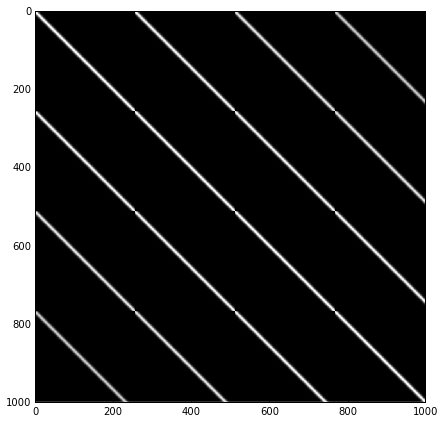

In [14]:
plt.imshow(D[:1000, :1000])

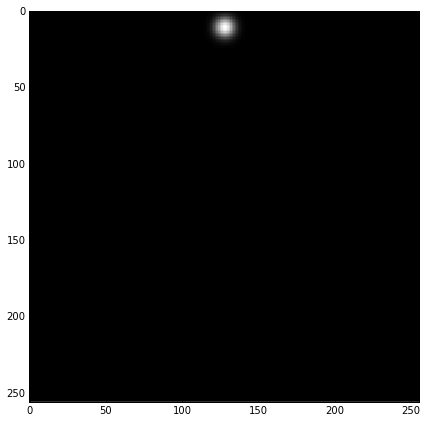

In [15]:
plt.imshow(D[:,10*256+128].reshape(256,256))

In [16]:
D.shape

(65536, 65536)

In [ ]:
%prun rho = np.dot(D.T,Y)

In [ ]:
whos

In [17]:
rho.shape

(16384, 100)

In [18]:
wcent = np.argmax(rho.sum(axis=1))
wcent = (int(wcent/128), np.mod(wcent, 128))

In [19]:
wcent

(107, 60)

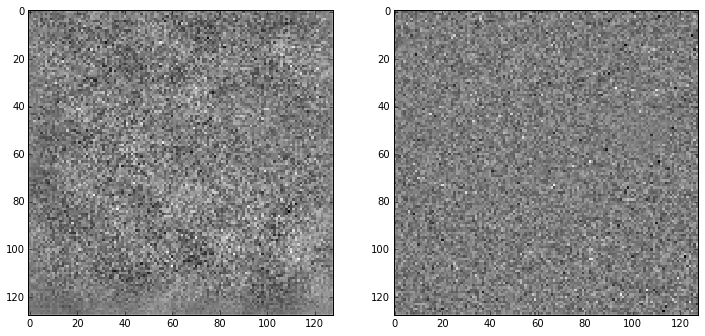

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].imshow(rho.mean(axis=1).reshape(128,128))
ax[1].imshow(Y.mean(axis=1).reshape(128,128))

In [22]:
def greedy_neuron_id(Y, K, tau, w):
    med = np.median(Y, axis=1)
    MED = np.array(Y.shape[0]*[med])
    Y = Y - MED
    R = Y.copy()
    D = gaussian_blur_matrix(Y.shape[0], w, tau)
    for i in range(K):
        rho = np.dot(D.T, R)
        v = 

In [21]:
whos

Variable     Type       Data/Info
---------------------------------
D            ndarray    16384x16384: 268435456 elems, type `float64`, 2147483648 bytes (2048 Mb)
Y            ndarray    16384x100: 1638400 elems, type `float64`, 13107200 bytes (12 Mb)
ax           ndarray    3: 3 elems, type `object`, 24 bytes
data         ndarray    16384x100: 1638400 elems, type `uint16`, 3276800 bytes (3 Mb)
datacols     int        18000
datafile     str        /home/michael/datac/14031<...>channel1_minitestdata.tif
datarows     int        262144
dshape       tuple      n=3
fig          Figure     Figure(1200x480)
meanim       ndarray    128x128: 16384 elems, type `float64`, 131072 bytes (128 kb)
mediandata   ndarray    16384: 16384 elems, type `float64`, 131072 bytes (128 kb)
medianim     ndarray    128x128: 16384 elems, type `float64`, 131072 bytes (128 kb)
mem          int        4096
mpld3        module     <module 'mpld3' from '/ho<...>ages/mpld3/__init__.pyc'>
neuralyzer   module     <module